# Resonant depolarization

In [1]:
%matplotlib widget

In [2]:
import xtrack as xt
import xpart as xp
import xobjects as xo
import numpy as np
import matplotlib.pyplot as plt

### Load and configure ring model

In [3]:
line = xt.Line.from_json('lattice/lep_sol.json')
line.particle_ref.anomalous_magnetic_moment=0.00115965218128
line.particle_ref.gamma0 = 89207.78287659843 # to have a spin tune of 103.45
spin_tune = line.particle_ref.anomalous_magnetic_moment[0]*line.particle_ref.gamma0[0]

Loading line from dict:   0%|          | 0/9667 [00:00<?, ?it/s]

Done loading line from dict.           


In [4]:
# RF ON
line['vrfc231'] = 12.65  # qs=0.6 with radiation

# Solenoids and spin bumps off
line['on_solenoids'] = 0
line['on_spin_bumps'] = 0
line['on_coupling_corrections'] = 0

In [5]:
# Match tunes to those used during polarization measurements
# https://cds.cern.ch/record/282605
opt = line.match(
    method='4d',
    solve=False,
    vary=xt.VaryList(['kqf', 'kqd'], step=1e-4),
    targets=xt.TargetSet(qx=65.10, qy=71.20, tol=1e-4)
)
opt.solve()

                                             
Optimize - start penalty: 2.606                             
Matching: model call n. 9 penalty = 3.9777e-05              
Optimize - end penalty:  3.97769e-05                            


### Twiss to get $n_0$

In [6]:
tw = line.twiss(spin=True)

### Install a kicker to have a sinusoidal excitation with changing frequency

In [7]:
from chirp_kicker import VerticalChirpKicker
kicker = VerticalChirpKicker(
    k0sl=5e-6, # peak value
    q_start=0.44,
    q_span=0.003,
    num_turns=15000, # Duration of the scan
)
line.insert('spin_kicker', obj=kicker, at='bfkv1.qs18.r2@start')

Slicing line:   0%|          | 0/9550 [00:00<?, ?it/s]

 ### Three scans in different spin-tune ranges

In [8]:
# enable spin tracking
line.configure_spin('auto')

# Scan in the range (0.44, 0.443)
q0_scan_1 = 0.44
kicker.q_start = q0_scan_1
p = tw.particle_on_co.copy()
line.track(p, num_turns=15000, turn_by_turn_monitor=True, with_progress=1000)
spin_y_scan1 = line.record_last_track.spin_y[0, :]

# Scan in the range (0.448, 0.451)
q0_scan_2 = 0.448
kicker.q_start = q0_scan_2
p = tw.particle_on_co.copy()
line.track(p, num_turns=15000, turn_by_turn_monitor=True, with_progress=1000)
spin_y_scan2 = line.record_last_track.spin_y[0, :]

# Scan in the range (0.453, 0.456)
q0_scan_3 = 0.453
kicker.q_start = q0_scan_3
p = tw.particle_on_co.copy()
line.track(p, num_turns=15000, turn_by_turn_monitor=True, with_progress=1000)
spin_y_scan3 = line.record_last_track.spin_y[0, :]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/15000 [00:00<?, ?it/s]

Tracking:   0%|          | 0/15000 [00:00<?, ?it/s]

Tracking:   0%|          | 0/15000 [00:00<?, ?it/s]

### Plot spin vs excitation frequency

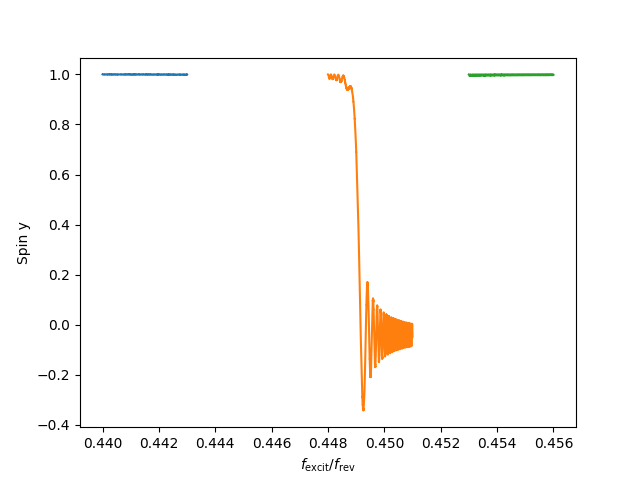

In [9]:
# Generate freq axes for the three scans
q_scan_1 = np.linspace(q0_scan_1, q0_scan_1+kicker.q_span, int(kicker.num_turns))
q_scan_2 = np.linspace(q0_scan_2, q0_scan_2+kicker.q_span, int(kicker.num_turns))
q_scan_3 = np.linspace(q0_scan_3, q0_scan_3+kicker.q_span, int(kicker.num_turns))

# Plot
plt.figure()
plt.plot(q_scan_1, spin_y_scan1)
plt.plot(q_scan_2, spin_y_scan2)
plt.plot(q_scan_3, spin_y_scan3)
plt.ylabel('Spin y')
l = plt.xlabel(r'$f_\text{excit} / f_\text{rev}$')